In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This project was executed with data gathered from University of Toronto CSC321 class in 2020. The main objective here was to determine whether an image of a shoe is the left or right shoe. The original picture dimension is 244 x 244 pixels.

Loading the training and test data, and separating the training data into training and validation.
Creating the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of students allocated to train, valid, or test
- `3` - the 3 pairs of shoes submitted by that student
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image submitted
by the 5th student.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair, submitted by
the same student.

In [ ]:
import glob
path = "/content/gdrive/My Drive/CSC321/data/train/*.jpg" 

files = {}
num_img = 0
max_stud = 0

for file in glob.glob(path):              #sorting the paths to save time
  num_img+=1
  filename = file.split("/")[-1]
  parms = filename.split("_")[0:3]
  stud = int(parms[0].split("u")[-1])
  pair = int(parms[1])-1
  
  if(parms[2] == "left"):
    lr = 0
  else:
    lr = 1 
  if stud not in files:
    files[stud] = [0,0,0,0,0,0]
  if stud > max_stud:
    max_stud = stud
  files[stud][2*pair + lr] = file
  
num_student = int(num_img/6)
train_data = np.zeros((int(num_student*0.8),3, 2, 224, 224, 3), dtype=int)
valid_data = np.zeros((int(num_student*0.21),3, 2, 224, 224, 3), dtype=int)
cur_stud_1 = 0 
cur_stud_2 = 0 
num_train = int(num_student*0.79)
num_valid = int(num_student*0.21)
for i in range(max_stud):
  if(i in files):
    if (cur_stud_1 <= num_train):
      for s in range(3):
        for l in range(2):
          filename = files[i][2*s+l]
          img = plt.imread(filename)           
          train_data[cur_stud_1,s,l,:,:,:] = img[:, :, :3].astype(int)
      cur_stud_1 += 1
    else:
      for s in range(3):
        for l in range(2):
          filename = files[i][2*s+l]
          img = plt.imread(filename)           
          valid_data[cur_stud_2,s,l,:,:,:] = img[:, :, :3].astype(int)
      cur_stud_1 += 1
      cur_stud_2 += 1

np.save("/content/gdrive/My Drive/CSC321/data/train_data.npy",train_data)
np.save("/content/gdrive/My Drive/CSC321/data/valid_data.npy",valid_data)

In [ ]:
train_data = np.load("/content/gdrive/My Drive/CSC321/data/train_data.npy")
valid_data = np.load("/content/gdrive/My Drive/CSC321/data/valid_data.npy")

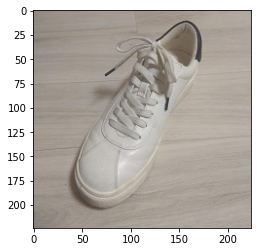

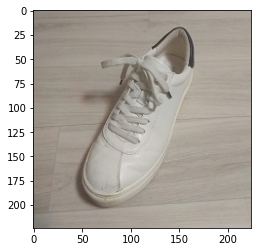

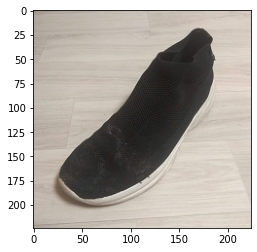

In [ ]:
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]) # right shoe of second pair submitted by 5th student

Here, we wrote helper functions to help us with image manipulation and image generation.

In [ ]:
def concat(up, down):
  img = np.zeros((448, 224, 3), dtype=int)
  img[:224,:,:] = up
  img[224:,:,:] = down
  return img

#plt.imshow(concat(train_data[23,0,0,:,:,:],train_data[23,0,1,:,:,:]))

def generate_same_pair(data):
  N = data.shape[0]
  same_pair = np.zeros((3*N, 448,224,3), dtype= int)

  for i in range(N):
    
    same_pair[3*i] = concat(data[i,0,0,:,:,:],data[i,0,1,:,:,:])
    same_pair[3*i+1] = concat(data[i,1,0,:,:,:],data[i,1,1,:,:,:])
    same_pair[3*i+2] = concat(data[i,2,0,:,:,:],data[i,2,1,:,:,:])

  return same_pair

def generate_different_pair(data):
  N = data.shape[0]
  different_pair = np.zeros((3*N, 448,224,3), dtype= int)

  for i in range(N):
    
    different_pair[3*i] = concat(data[i,0,0,:,:,:],data[i,1,1,:,:,:])
    different_pair[3*i+1] = concat(data[i,1,0,:,:,:],data[i,2,1,:,:,:])
    different_pair[3*i+2] = concat(data[i,2,0,:,:,:],data[i,0,1,:,:,:])

  return different_pair

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


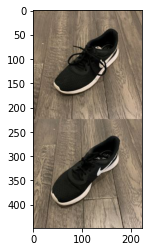

In [ ]:
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]) # should show 2 shoes from the same pair

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


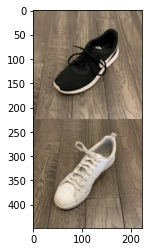

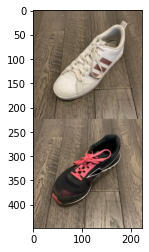

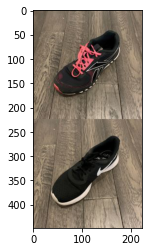

In [ ]:
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
different_pair = generate_different_pair(train_data)
print(different_pair.shape) # should be [N*3, 448, 224, 3]

plt.figure()
plt.imshow(different_pair[0]) # should show 2 shoes from different pairs

plt.figure()
plt.imshow(different_pair[1]) # should show 2 shoes from different pairs

plt.figure()
plt.imshow(different_pair[2]) # should show 2 shoes from different pairs

# CONVOLUTIONAL NEURAL NETWORKS

Here, we defined the CNN class with appropriate layers and implemented the forward pass.

In [ ]:
class CNN(nn.Module):
    def __init__(self, n = 4):
        
        super(CNN, self).__init__()
        self.n = n
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(8*n*28*14, 100)
        self.fc2 = nn.Linear(100, 2)
        self.fc3 = nn.Linear(2, 1)

    def forward(self, x):
      #3x448x224
      x = self.pool(torch.relu(self.conv1(x.float())))
      #nx224x112
      x = self.pool(torch.relu(self.conv2(x.float())))
      #2nx112*56
      x = self.pool(torch.relu(self.conv3(x.float())))
      #4nx56x28
      x = self.pool(torch.relu(self.conv4(x.float())))
      #8nx28x14
      x = x.view(-1, 8*self.n *28*14)
      x = self.fc1(x)
      x = self.fc2(x)
      return x 

In [ ]:
#test
model = CNN()
x = torch.rand((1,3,448,224))
model.forward(x).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 2])

In [ ]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()
        self.n = n
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=n, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(4*n*28*14, 100)
        self.fc2 = nn.Linear(100, 2)
    
    def forward(self, x):
      img = np.zeros((32,224,224,6), dtype=int)
      up = np.zeros((32,224, 224, 3), dtype=int)
      down = np.zeros((32,224, 224, 3), dtype=int)
      down = x[:,:,224:,:]
      up = x[:,:,:224,:]


      img = torch.cat((up,down),dim = 1)
      x = img
      x = self.pool(torch.relu(self.conv1(x.float())))
      x = self.pool(torch.relu(self.conv2(x.float())))
      x = self.pool(torch.relu(self.conv3(x.float())))
      x = self.pool(torch.relu(self.conv4(x.float())))
      x = x.view(-1, 8*self.n *14*14)
      x = self.fc1(x)

      x = self.fc2(x)
      
      return x 

In [ ]:
#test
model = CNNChannel()
x = torch.rand((1,3,448,224))
model.forward(x)


tensor([[ 0.0828, -0.0372]], grad_fn=<AddmmBackward>)

In [ ]:
def get_accuracy(model, data, batch_size=50):
    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).view((-1,3,448,224))
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).view((-1,3,448,224))
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

In [ ]:
def save_checkpoint(state, is_best, filename='/content/gdrive/My Drive/CSC321/data/checkpoint.pth.tar'):
    if is_best:
        torch.save(state, filename)  # save checkpoint

# Training the Model

In [ ]:
def train_model(model, train_data, valid_data, batch_size=64, weight_decay=10,
          learning_rate=0.1, num_epochs=30,tot_plot = False, neg_plot = False,
                pos_plot = False , loss_plot = False, verbose = False):
     
    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)


    #Diffrent pair training
    df_pair = torch.tensor(generate_different_pair(train_data)).view((-1,3,448,224))
    df_label = torch.zeros((df_pair.shape[0]),dtype=int)

    #Same pair training
    sm_pair = torch.tensor(generate_same_pair(train_data)).view((-1,3,448,224))
    sm_label = torch.ones((df_pair.shape[0]),dtype=int)

    #Diffrent pair training
    df_pair_val = torch.tensor(generate_different_pair(valid_data)).view((-1,3,448,224))
    df_label_val = torch.zeros((df_pair.shape[0]),dtype=int)

    #Same pair validation
    sm_pair_val = torch.tensor(generate_same_pair(valid_data)).view((-1,3,448,224))
    sm_label_val = torch.ones((df_pair.shape[0]),dtype=int)

    

    #print(sm_pair.size())
    imgs = torch.cat((df_pair, sm_pair), 0)
    labels = torch.cat((df_label, sm_label), 0)
    #print(imgs.size())
    imgs_val = torch.cat((df_pair_val, sm_pair_val), 0)
    labels_val = torch.cat((df_label_val, sm_label_val), 0)
  
    data = TensorDataset(imgs,labels)
    acc_list = []
    val_acc_neg = []
    val_acc_pos = []
    tot_val_acc = []
    tot_train_acc = []
    best_accuracy = 0
    loss = 0
    correct = 0
    # track learning curve
    iters, losses, train_acc_pos, train_acc_neg = [], [], [], []
    # training
    n = 0 # the number of iterations (for plotting)
    i = 0
    train_loader = torch.utils.data.DataLoader(data,batch_size=batch_size,shuffle=True, drop_last=True)
    for epoch in range(num_epochs):
        #shuffle training 
        for i, (images, labels) in enumerate(train_loader):
            # Run the forward pass

            model.train()
            out = model(images)
            loss = criterion(out, labels)
            #losses.append(loss.item())

            # Backprop and perform Adam optimisation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            n+=1
          
        #print(out[0:5])
        loss = float(loss)/batch_size
        tacc = get_accuracy(model, train_data)
        vacc = get_accuracy(model, valid_data)
        #tacc = (0,0)
        #vacc= (0,0)
        if (verbose):
          print("Iter %d; Loss %f; Train Acc neg %.3f; Train Acc pos %.3f; Total Acc %.3f" % (n, loss, tacc[0], tacc[1], (tacc[0]+tacc[1])/2))
        
        iters.append(n)
        losses.append(loss)
        #train_acc.append(tacc)
        val_acc_neg.append(vacc[0])
        val_acc_pos.append(vacc[1])

        train_acc_pos.append(tacc[1])
        train_acc_neg.append(tacc[0])

        tot_val_acc.append((vacc[0]+vacc[1])/2)
        tot_train_acc.append((tacc[0]+tacc[1])/2)

        #Checkpointing
        if (best_accuracy < tot_val_acc[-1]):
          best_accuracy = tot_val_acc[-1]
          print("Best Accuracy:" + str(best_accuracy))
          torch.save(model.state_dict(), '/content/gdrive/My Drive/CSC321/data/checkpoint.pth.tar')

      
    plt.figure()
    # plotting
    if (loss_plot):
      plt.subplot(2,2,1)
      plt.title("Loss Curve")
      plt.plot(iters, losses, label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      #plt.show()

    if (neg_plot):
      plt.subplot(2,2,2)
      plt.title("Accuracy Curve Negative")
      plt.plot(iters,train_acc_neg, label="Train")
      plt.plot(iters,val_acc_neg, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      #plt.show()

    if (pos_plot):
      plt.subplot(2,2,3)
      plt.title("Accuracy Curve Positive")
      plt.plot(iters,train_acc_pos, label="Train")
      plt.plot(iters,val_acc_pos, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      #plt.show()

    if (tot_plot):
      plt.subplot(2,2,4)
      plt.title("Accuracy Curve Total")
      plt.plot(iters,tot_train_acc, label="Train")
      plt.plot(iters,tot_val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      #plt.show()


    plt.show()
    if (verbose):
      print("Final Negative Training Accuracy: {}".format(train_acc_neg[-1]))
      print("Final Negative Validation Accuracy: {}".format(val_acc_neg[-1]))
      print("Final Positive Training Accuracy: {}".format(train_acc_pos[-1]))
      print("Final Positive Validation Accuracy: {}".format(val_acc_pos[-1]))
        

Iter 1; Loss 0.122488; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Best Accuracy:0.5
Iter 2; Loss 3.408911; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 3; Loss 1.526737; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 4; Loss 0.729425; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 5; Loss 1.222090; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 6; Loss 0.810515; Train Acc neg 1.000; Train Acc pos 1.000; Total Acc 1.000
Best Accuracy:0.6666666666666666
Iter 7; Loss 0.045514; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 8; Loss 0.599928; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 9; Loss 0.723493; Train Acc neg 0.000; Train Acc pos 1.000; Total Acc 0.500
Iter 10; Loss 0.430556; Train Acc neg 1.000; Train Acc pos 1.000; Total Acc 1.000
Iter 11; Loss 0.022241; Train Acc neg 1.000; Train Acc pos 0.000; Total Acc 0.500
Iter 12; Loss 0.237774; Train Acc neg 1.000; Train Acc p

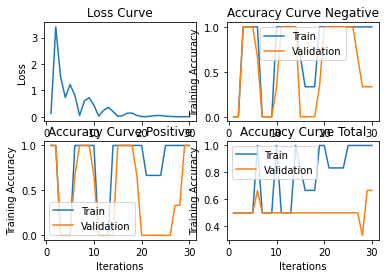

Final Negative Training Accuracy: 1.0
Final Negative Validation Accuracy: 0.3333333333333333
Final Positive Training Accuracy: 1.0
Final Positive Validation Accuracy: 1.0


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

model = CNN(8)
td = train_data[:1]
vd = valid_data[:1]
train_model(model, td, vd, batch_size=6, weight_decay=0.01,
          learning_rate=0.0001, num_epochs=30 ,loss_plot = True, neg_plot= True, pos_plot = True, tot_plot = True, verbose = True)

In [ ]:
model2 = CNNChannel(8)
model2.load_state_dict(torch.load('/content/gdrive/My Drive/CSC321/data/best_acc.tar'))

tacc = get_accuracy(model2, train_data, batch_size=64)
vacc = get_accuracy(model2, valid_data, batch_size=64)

print("Total Validation Acc %.3f" % ((vacc[0]+vacc[1])/2))
print("Total Train Acc %.3f" % ((tacc[0]+tacc[1])/2))



Total Validation Acc 0.710
Total Train Acc 0.904


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

model = CNNChannel()

train_model(model, train_data, valid_data, batch_size=32, weight_decay=0.01,
          learning_rate=0.0001, num_epochs=30 ,loss_plot = True, neg_plot= True, pos_plot = True)